In [1]:
import random
import os
from datetime import datetime
from collections import OrderedDict
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.min_rows', 50)

In [3]:
# Path to data location
DATA_DIR = '../data/price-volume-data-for-all-us-stocks-etfs/Data'

# TODO: Update from Small to Regular (delete Small)
if True:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs')
else:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks_Small')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs_Small')

FILE_SUFFIX = '.us.txt'

In [61]:
def get_tickers(dirname):
    tickers = []
    for file in os.listdir(dirname):
        # This dataset includes empty files which we exclude here.
        if os.stat(os.path.join(dirname, file)).st_size > 0:
            tickers.append(file.replace(FILE_SUFFIX, ''))

    return tickers

def get_etf_tickers():
    return sorted(get_tickers(ETF_DATA_DIR))

def get_stock_tickers():
    return sorted(get_tickers(STOCK_DATA_DIR))

def get_all_tickers():
    return sorted(get_etf_tickers() + get_stock_tickers())

def get_csv_data(ticker, start_date=None, end_date=None):
    ticker = ticker.lower()

    if ticker in get_etf_tickers():
        dirname = ETF_DATA_DIR
    else:
        dirname = STOCK_DATA_DIR

    result = pd.DataFrame()
    csv = pd.read_csv(os.path.join(dirname, ticker + FILE_SUFFIX))
    result = pd.DataFrame({'date': csv['Date'], 'ticker': ticker, 'price': csv['Close'], 'volume': csv['Volume']})
    result['date'] = result['date'].map(lambda t: datetime.strptime(t, '%Y-%m-%d')).to_numpy()
    
    if start_date is not None:
        result = result[result['date'] >= start_date]
        
    if end_date is not None:
        result = result[result['date'] <= end_date]

    result.index = result.date
    
    # Making sure to only include weekdays
    result['dayofweek'] = pd.DatetimeIndex(result.index).dayofweek
    result = result[(result.dayofweek != 5) & (result.dayofweek != 6)]

    return result

In [68]:
t = get_csv_data('spy', start_date='2016-01-01', end_date='2017-01-01')
t.tail()

,date,ticker,price,volume,dayofweek
date,,,,,
2016-12-23,2016-12-23,spy,222.54,37175258,4
2016-12-27,2016-12-27,spy,223.10,43232763,1
2016-12-28,2016-12-28,spy,221.26,64927525,2
2016-12-29,2016-12-29,spy,221.21,49307251,3
2016-12-30,2016-12-30,spy,220.39,110550190,4


In [6]:
# TODO: 
class EquityData:
    def __init__(self, date_list, price_list):
        self.date = date_list
        self.price = price_list
        self.dates = self.date
        self.prices = self.price

    def __len__(self):
        return len(self.date)
    
    def __getitem__(self, idx):
        return type(self)(self.dates[idx], self.prices[idx])

In [7]:
example_ticker = 'spy'

In [8]:
stocks = {}

In [50]:
from abc import ABC, abstractmethod

class Strategy(ABC):

    def __init__(self):
        self.signals = []

    def buy_signal(self, date):
        self.signals.append([self.ticker, date, 'buy'])
        #print(self.signals[-1])

    def sell_signal(self, date):
        self.signals.append([self.ticker, date, 'sell'])
        #print(self.signals[-1])

    def get_signals(self):
        signals_df = pd.DataFrame(data=self.signals, columns=['ticker', 'date', 'signal'])
        signals_df.index = signals_df.date
        return signals_df
    
    @abstractmethod
    def precalc(self, data):
        pass
    
    @abstractmethod
    def execute(self, data):
        pass

    @abstractmethod
    def plot(self, data):
        pass

In [80]:
class SimpleMovingAvgCrossOverStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()

        self.ticker = ticker
        
        if config:
            self.sma_short = config['sma_short']
            self.sma_long = config['sma_long']
        else:
            self.sma_short = 100
            self.sma_long = 300

        self.invested = False
        
    def precalc(self, data):
        data['sma_short'] = data['price'].rolling(self.sma_short, min_periods=self.sma_short).mean()
        data['sma_long'] = data['price'].rolling(self.sma_long, min_periods=self.sma_long).mean()

    def execute(self, data):
        for _, data in data.iterrows():
            if data['sma_short'] > data['sma_long'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['sma_short'] < data['sma_long'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False
                
    def plot(self, data):
        plt.plot(data.date, data['sma_short'], label='{}-Day Moving Avg'.format(self.sma_short), 
                 color='darkorange', zorder=0)
        plt.plot(data.date, data['sma_long'], label='{}-Day Moving Avg'.format(self.sma_long), 
                 color='brown', zorder=0)

In [81]:
class BuyAndHoldStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker.lower()
        self.invested = False
        
    def precalc(self, data):
        pass

    def execute(self, data):
        for _, data in data.iterrows():
            if not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
    
    def plot(self, data):
        pass

In [82]:
class BandStrategy(Strategy):

    def execute(self, data):
        for _, data in data.iterrows():
            if data['price'] < data['band_low'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['price'] > data['band_high'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False

    
class BollingerBandStrategy(BandStrategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker
        
        if config:
            pass
        else:
            self.sma = 20
            self.sd = 2

        self.invested = False

    def precalc(self, data):
        data['sma'] = data['price'].rolling(self.sma, min_periods=self.sma).mean()
        data['sd'] = data['price'].rolling(self.sma, min_periods=self.sma).std()
        data['band_high'] = data['sma'] + self.sd * data['sd']
        data['band_low'] = data['sma'] - self.sd * data['sd']
        
    def plot(self, data):
        plt.fill_between(data.date, data['band_high'], data['band_low'],
                         label='{}-Day Band'.format(self.sma), color='pink', zorder=-1)
        plt.plot(data.date, data['sma'], label='{}-Day Moving Avg'.format(self.sma), 
                 color='blue', zorder=0)

SMA


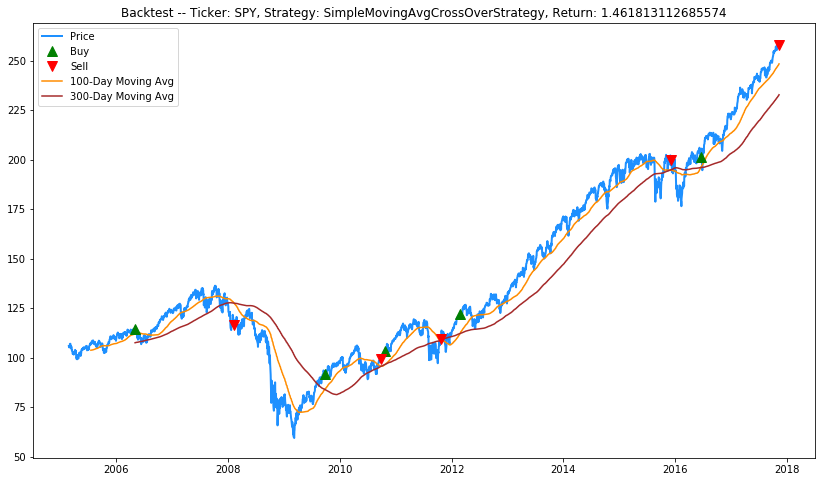

BuyAndHold


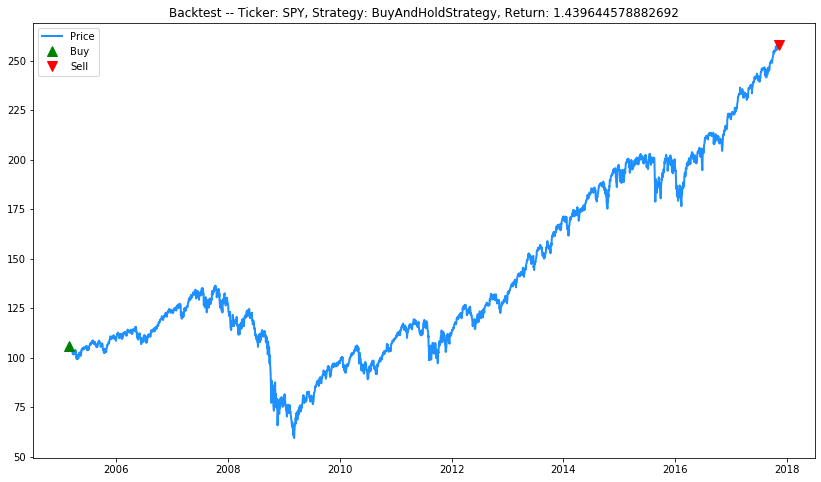

Bollinger


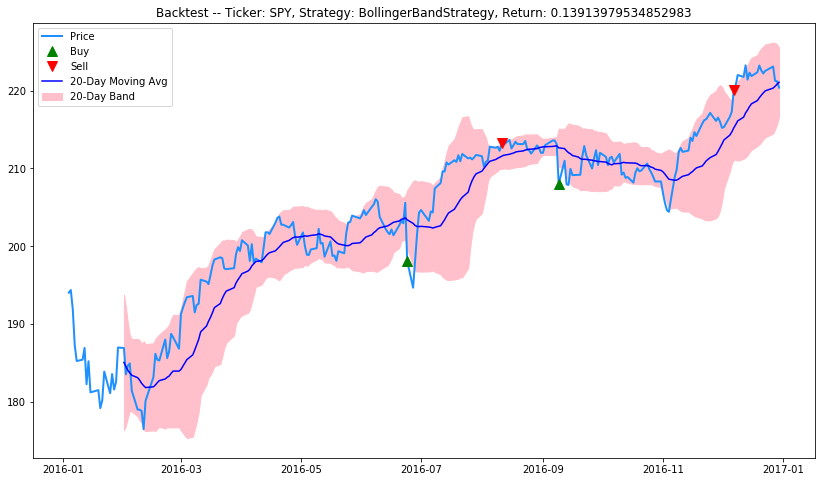

In [97]:
class Backtest():

    def __init__(self, strategy_cls, ticker, config={}, start_date=None, end_date=None):
        self.ticker = ticker.lower()
        self.config = config
        self.start_date = start_date
        self.end_date = end_date
        self.strategy = strategy_cls(ticker, config)
        self.data = None
        self.signals = None
        self.buys = None
        self.sells = None

    def run(self):
        self.data = get_csv_data(self.ticker, self.start_date, self.end_date)
        self.strategy.precalc(self.data)
        self.strategy.execute(self.data)

        self.signals = self.strategy.get_signals()
        self.buys = self.data.loc[self.signals[self.signals.signal == 'buy'].index]['price']
        self.sells = self.data.loc[self.signals[self.signals.signal == 'sell'].index]['price']
        if len(self.buys) > len(self.sells):
            self.sells = self.sells.append(backtest.data['price'][[-1]])

        return self.calc_return()

    def calc_return(self):
        if not all(self.buys.index < self.sells.index):
            raise Exception('Strategy buys and sells are not consistent.')

        return np.prod(self.sells.values / self.buys.values) - 1

    def plot(self):
        fig = plt.figure(figsize=(14,8))

        plt.title('Backtest -- Ticker: {}, Strategy: {}, Return: {}'.format(
            self.ticker.upper(), type(self.strategy).__name__, float(self.calc_return())))

        plt.plot(self.data.date, self.data.price, color='dodgerblue', lw=2., label='Price', zorder=0)

        plt.plot(self.data.loc[backtest.buys.index].index, self.data.price[backtest.buys.index], 
                 '^', markersize=10, color='g', label='Buy')
        plt.plot(self.data.loc[backtest.sells.index].index, self.data.price[backtest.sells.index],
                 'v', markersize=10, color='r', label='Sell')
        
        self.strategy.plot(self.data)

        plt.legend()
        plt.show()

example_ticker = 'SPY'

print('SMA')
backtest = Backtest(SimpleMovingAvgCrossOverStrategy, example_ticker)
backtest.run()
backtest.plot()

print('BuyAndHold')
backtest = Backtest(BuyAndHoldStrategy, example_ticker)
backtest.run()
backtest.plot()
    
print('Bollinger')
backtest = Backtest(BollingerBandStrategy, example_ticker, start_date='2016-01-01', end_date='2016-12-31')
backtest.run()
backtest.plot()

In [93]:
    def generate_positions(self):
        positions = pd.DataFrame(index=signals.index).fillna(0.0)
        positions[self.symbol] = 100*signals['signal']   # This strategy buys 100 shares
        return positions

In [94]:
    def backtest_portfolio(self):
        portfolio = self.positions*self.bars['Adj Close']
        pos_diff = self.positions.diff()

        portfolio['holdings'] = (self.positions*self.bars['Adj Close']).sum(axis=1)
        portfolio['cash'] = self.initial_capital - (pos_diff*self.bars['Adj Close']).sum(axis=1).cumsum()

        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio